# play around with a trained model from outputs/

In [15]:
import os
import argparse
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

def load_metrics(path):
    """Load training metrics from CSV file or JSON file.
    
    This function handles several scenarios:
    1. Direct path to metrics file (CSV or JSON)
    2. Path to a directory containing metrics files
    3. Path to best_model directory
    4. Path to a parent directory containing best_model
    """
    # Check if path is a directory or file
    if os.path.isfile(path):
        # Direct path to a metrics file
        if path.endswith('.csv'):
            print(f"Loading metrics from CSV file: {path}")
            return pd.read_csv(path)
        elif path.endswith('.json'):
            print(f"Loading metrics from JSON file: {path}")
            with open(path, 'r') as f:
                data = json.load(f)
            if isinstance(data, list):
                return pd.DataFrame(data)
            elif 'metrics' in data:
                return pd.DataFrame(data['metrics'])
            else:
                return pd.DataFrame([data])
    
    # Directory handling
    if os.path.isdir(path):
        # First check if path itself is a best_model directory
        metrics_in_dir = os.path.join(path, "metrics.json")
        if os.path.exists(metrics_in_dir):
            print(f"Loading metrics from: {metrics_in_dir}")
            with open(metrics_in_dir, 'r') as f:
                data = json.load(f)
            return pd.DataFrame(data)
        
        # Check common filenames in the directory
        csv_path = os.path.join(path, "training_metrics.csv")
        json_path = os.path.join(path, "training_metrics.json")
        
        if os.path.exists(csv_path):
            print(f"Loading metrics from CSV: {csv_path}")
            return pd.read_csv(csv_path)
        elif os.path.exists(json_path):
            print(f"Loading metrics from JSON: {json_path}")
            with open(json_path, 'r') as f:
                data = json.load(f)
            return pd.DataFrame(data)
        
        # Check if best_model directory exists within this path
        best_model_dir = os.path.join(path, "best_model")
        if os.path.exists(best_model_dir) and os.path.isdir(best_model_dir):
            best_model_json = os.path.join(best_model_dir, "metrics.json")
            if os.path.exists(best_model_json):
                print(f"Loading metrics from best model: {best_model_json}")
                with open(best_model_json, 'r') as f:
                    data = json.load(f)
                return pd.DataFrame(data)
        
        # Try to find in the latest checkpoint
        try:
            checkpoints = [d for d in os.listdir(path) if d.startswith("checkpoint-")]
            if checkpoints:
                latest_checkpoint = sorted(checkpoints, key=lambda x: int(x.split("-")[1]))[-1]
                checkpoint_json = os.path.join(path, latest_checkpoint, "metrics.json")
                if os.path.exists(checkpoint_json):
                    print(f"Loading metrics from latest checkpoint: {checkpoint_json}")
                    with open(checkpoint_json, 'r') as f:
                        data = json.load(f)
                    return pd.DataFrame(data)
        except (FileNotFoundError, ValueError, IndexError) as e:
            print(f"Error checking checkpoints: {e}")
    
    print(f"No metrics found at path: {path}")
    return None

def load_config(path):
    """Load the full configuration from the provided path."""
    # Check if path is a directory or file
    if os.path.isfile(path):
        if path.endswith('.json'):
            print(f"Loading config from file: {path}")
            with open(path, 'r') as f:
                return json.load(f)
        return None
    
    # Directory handling
    if os.path.isdir(path):
        # Check if this is already a model directory with config
        config_in_dir = os.path.join(path, "config.json")
        if os.path.exists(config_in_dir):
            with open(config_in_dir, 'r') as f:
                model_config = json.load(f)
            
            # Look for training args
            training_args = os.path.join(path, "training_args.json")
            if os.path.exists(training_args):
                with open(training_args, 'r') as f:
                    training_config = json.load(f)
                return {
                    "model": model_config,
                    "training": training_config
                }
            return {"model": model_config}
        
        # Common config filenames
        config_path = os.path.join(path, "full_config.json")
        if os.path.exists(config_path):
            with open(config_path, 'r') as f:
                return json.load(f)
        
        # Check best_model directory
        best_model_dir = os.path.join(path, "best_model")
        if os.path.exists(best_model_dir) and os.path.isdir(best_model_dir):
            best_model_config = os.path.join(best_model_dir, "config.json")
            training_args = os.path.join(best_model_dir, "training_args.json")
            
            if os.path.exists(best_model_config):
                with open(best_model_config, 'r') as f:
                    model_config = json.load(f)
                
                if os.path.exists(training_args):
                    with open(training_args, 'r') as f:
                        training_config = json.load(f)
                    return {
                        "model": model_config,
                        "training": training_config
                    }
                return {"model": model_config}
    
    print(f"No configuration found at path: {path}")
    return None

def plot_metrics(df, output_dir=None, show=True):
    """Plot training metrics."""
    if df is None or len(df) == 0:
        print("No data to plot.")
        return
    
    # Set up the plots
    plt.style.use('seaborn-v0_8-darkgrid')
    
    # Create figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Training Loss
    if 'train_loss' in df.columns:
        ax = axes[0, 0]
        sns.lineplot(data=df, x='step', y='train_loss', ax=ax, marker='o')
        ax.set_title('Training Loss vs Steps', fontsize=14)
        ax.set_xlabel('Steps', fontsize=12)
        ax.set_ylabel('Loss', fontsize=12)
        ax.grid(True)
    
    # Plot 2: Evaluation Loss and Perplexity
    if 'eval_loss' in df.columns:
        ax = axes[0, 1]
        sns.lineplot(data=df, x='step', y='eval_loss', ax=ax, marker='o', label='Loss')
        ax.set_title('Evaluation Loss vs Steps', fontsize=14)
        ax.set_xlabel('Steps', fontsize=12)
        ax.set_ylabel('Loss', fontsize=12)
        
        if 'eval_perplexity' in df.columns:
            # Create secondary y-axis for perplexity
            ax2 = ax.twinx()
            sns.lineplot(data=df, x='step', y='eval_perplexity', ax=ax2, marker='o', color='red', label='Perplexity')
            ax2.set_ylabel('Perplexity', fontsize=12, color='red')
            
            # Create combined legend
            lines1, labels1 = ax.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
            ax2.get_legend().remove()
        
        ax.grid(True)
    
    # Plot 3: Learning Rate
    if 'learning_rate' in df.columns:
        ax = axes[1, 0]
        sns.lineplot(data=df, x='step', y='learning_rate', ax=ax, marker='o')
        ax.set_title('Learning Rate vs Steps', fontsize=14)
        ax.set_xlabel('Steps', fontsize=12)
        ax.set_ylabel('Learning Rate', fontsize=12)
        ax.grid(True)
    
    # Plot 4: Memory Usage
    if 'memory_used_mb' in df.columns:
        ax = axes[1, 1]
        sns.lineplot(data=df, x='step', y='memory_used_mb', ax=ax, marker='o')
        ax.set_title('GPU Memory Usage vs Steps', fontsize=14)
        ax.set_xlabel('Steps', fontsize=12)
        ax.set_ylabel('Memory (MB)', fontsize=12)
        ax.grid(True)
    
    plt.tight_layout()
    
    # Save the figure if output_dir provided
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        fig_path = os.path.join(output_dir, 'training_metrics.png')
        plt.savefig(fig_path, dpi=300)
        print(f"Figure saved to {fig_path}")
    
    if show:
        plt.show()

Loading metrics from JSON file: /home/marshall/lmodel/outputs/lm-wikitext/best_model/metrics.json
Loading config from file: /home/marshall/lmodel/outputs/lm-wikitext/best_model/config.json


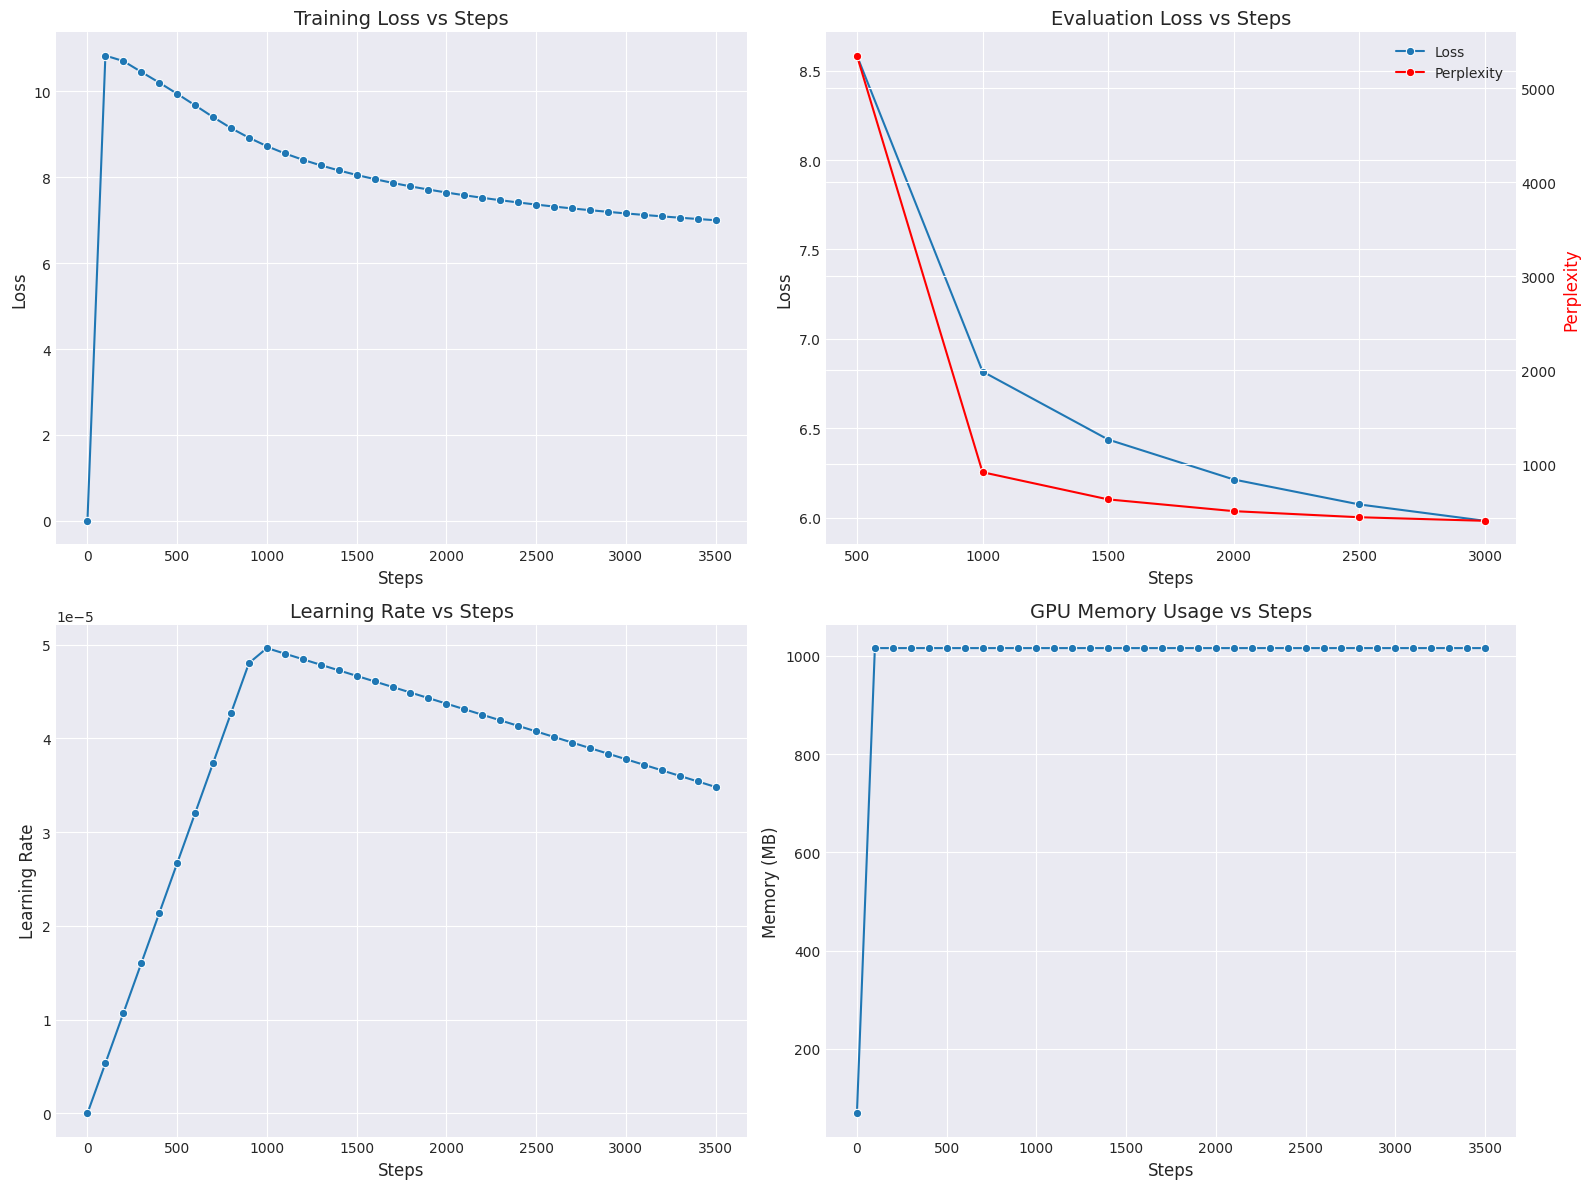

In [22]:
metrics_df = load_metrics('/home/marshall/lmodel/outputs/lm-wikitext/best_model/metrics.json')
config = load_config('/home/marshall/lmodel/outputs/lm-wikitext/best_model/config.json')

plot_metrics(metrics_df)